# Folding Strategy

REP implements folding strategy as one more metaestimator.

When we don't have enough data to split data on train/test, we're stick to k-folding cross-validation scheme.
Folding becomes the only way when you use some multi-staged stacking algorithm.

Usually we split training data into folds manually, but this is annoying and not reliable. REP has FoldingClassifier and FoldingRegressor, which do this automatically.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Loading data

### download particle identification Data Set from UCI

In [2]:
!cd toy_datasets; wget -O MiniBooNE_PID.txt -nc --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/00199/MiniBooNE_PID.txt

File `MiniBooNE_PID.txt' already there; not retrieving.


In [3]:
import numpy, pandas
from rep.utils import train_test_split
from sklearn.metrics import roc_auc_score

data = pandas.read_csv('toy_datasets/MiniBooNE_PID.txt', sep='\s*', skiprows=[0], header=None, engine='python')
labels = pandas.read_csv('toy_datasets/MiniBooNE_PID.txt', sep=' ', nrows=1, header=None)
labels = [1] * labels[1].values[0] + [0] * labels[2].values[0]
data.columns = ['feature_{}'.format(key) for key in data.columns]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.5)

# Training variables

In [4]:
variables = list(data.columns)

# Folding strategy

`FoldingClassifier` implements the same interface as all classifiers, but with some difference:

* prediction methods have additional parameter "vote\_function" (example folder.predict(X, __vote\_function=None)__), which is used to combine all classifiers' predictions. 

In [5]:
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.metaml import FoldingClassifier

## Define folding model

In [6]:
%%time
n_folds = 4
folder = FoldingClassifier(GradientBoostingClassifier(n_estimators=30), 
                           n_folds=n_folds, features=variables, 
                           parallel_profile='threads-4')
folder.fit(train_data, train_labels)

CPU times: user 2min 43s, sys: 3.01 s, total: 2min 46s
Wall time: 47 s


## Default prediction (predict i_th_ fold by i_th_ classifier)

In this case each sample will be predict by estimator that was not using this particular sample in training. 

When you apply this prediction to some new data (not the same was passed in training), it will predict each sample by random estimator.

In [7]:
folder.predict_proba(train_data)

KFold prediction using folds column


array([[ 0.79281896,  0.20718104],
       [ 0.96200905,  0.03799095],
       [ 0.23027741,  0.76972259],
       ..., 
       [ 0.9431413 ,  0.0568587 ],
       [ 0.48068844,  0.51931156],
       [ 0.87707187,  0.12292813]])

## Voting prediction (predict i_th_ fold by all classifiers and take value, which is calculated by `vote_function`)

It makes sense to use all classifier to predict new data, because averaging makes predictions more stable.

In [8]:
# definition of mean function, which combines all predictions
def mean_vote(x):
    return numpy.mean(x, axis=0)

In [9]:
folder.predict_proba(test_data, vote_function=mean_vote)

KFold prediction with voting function


array([[ 0.51136471,  0.48863529],
       [ 0.96878304,  0.03121696],
       [ 0.20340611,  0.79659389],
       ..., 
       [ 0.12145289,  0.87854711],
       [ 0.95466483,  0.04533517],
       [ 0.81167832,  0.18832168]])

# Comparison of folds

Again use `ClassificationReport` class to compare different results. For folding classifier this report uses only __default prediction__.

## Report training dataset

In [10]:
from rep.data.storage import LabeledDataStorage
from rep.report import ClassificationReport
# add folds_column to dataset to use mask
train_data["FOLDS"] = folder._get_folds_column(len(train_data))
lds = LabeledDataStorage(train_data, train_labels)

report = ClassificationReport({'folding': folder}, lds)

KFold prediction using folds column


/Users/axelr/.conda/envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Signal distribution for each fold

Use `mask` parameter to plot distribution for the specific fold 

/Users/axelr/.conda/envs/rep/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


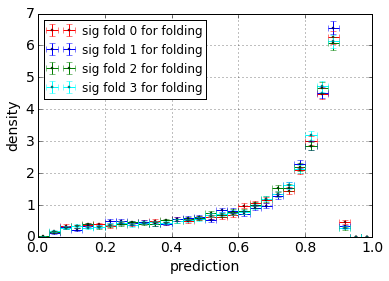

In [11]:
for fold_num in range(n_folds):
    report.prediction_pdf(mask="FOLDS == %d" % fold_num, labels_dict={1: 'sig fold %d' % fold_num}).plot()

### Background distribution for each fold

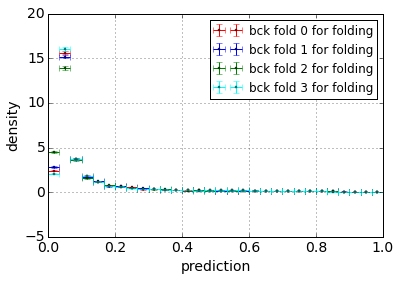

In [12]:
for fold_num in range(n_folds):
    report.prediction_pdf(mask="FOLDS == %d" % fold_num, labels_dict={0: 'bck fold %d' % fold_num}).plot()

### ROCs (each fold used as test dataset)

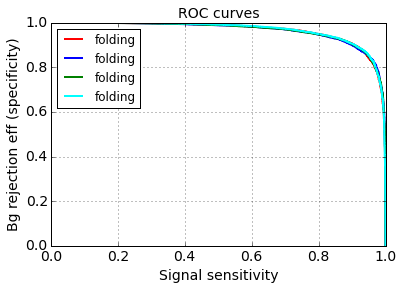

In [13]:
for fold_num in range(n_folds):
    report.roc(mask="FOLDS == %d" % fold_num).plot()

## Report for test dataset 

__NOTE__: Here vote function is None, so default prediction is used

In [14]:
lds = LabeledDataStorage(test_data, test_labels)

report = ClassificationReport({'folding': folder}, lds)

KFold prediction using folds column


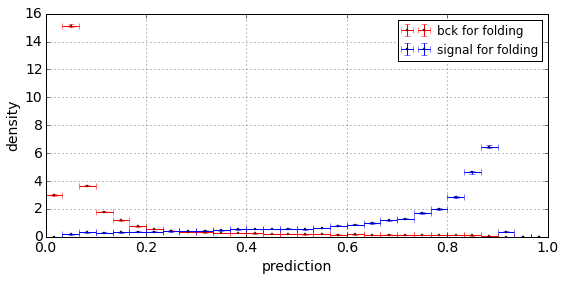

In [15]:
report.prediction_pdf().plot(new_plot=True, figsize = (9, 4))

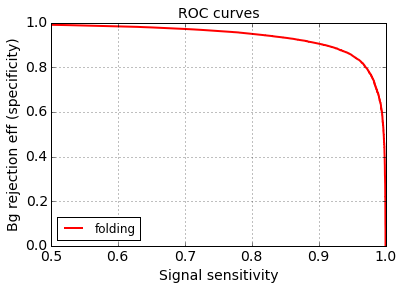

In [16]:
report.roc().plot(xlim=(0.5, 1))